# Explore sdata

In [ ]:
import harpy as hp

## 1. Read in the data

In [2]:
# If path is set to None, example data will be downloaded in the default cache folder of your os. Set this to a custom path to change this behaviour.
path = None # on Windows, set path (e.g. to r"c:\tmp")
#path = "/staging/leuven/stg_00143/spatial_data_training" # e.g. on HPC

In [ ]:
# Read in example data as sdata
import os
import tempfile
import uuid

from training_datasets import sdata_resolve

OUTPUT_DIR = tempfile.gettempdir() # The OUTPUT_DIR is the directory where the SpatialData .zarr will be saved. Change it to your output directory of choice.
#OUTPUT_DIR = "/staging/leuven/stg_00143/spatial_data_training/output_dir"

sdata = sdata_resolve(path=path, output=os.path.join(OUTPUT_DIR, f"sdata_{uuid.uuid4()}.zarr"))

In [ ]:
# Inspect SpatialData object
sdata

In [ ]:
# Check if the sdata is backed by a Zarr store
print("Check if sdata is backed by a Zarr store: ", sdata.is_backed())
print("Path to associated Zarr store: ", sdata.path)

In [ ]:
# Check contents of Zarr store
print( f"Content of {sdata.path}:" )
! ls {sdata.path} # On windows, use 'dir' instead of 'ls'
print( "\n" )

# Check contents of images directory in Zarr store
images_dir = os.path.join(sdata.path, "images")
print( f"Content of {images_dir}:" )
! ls {images_dir} # On windows, use 'dir' instead of 'ls'

Note: you can remove an element from the zarr store (e.g. on the command line with `rm -r dummy_image`), without 'breaking' the `SpatialData` object. After reloading it from the `.zarr` store, the element that was removed will no longer be an element of the `SpatialData` object.

If the `SpatialData` object is not backed by a `.zarr` store, elements can be removed in the Python shell via `del ...`.

In [ ]:
# Delete tiling_correction from sdata
del sdata.images["dummy_image"] # This deletes the element from memory, but does not remove the directory in the Zarr store.

# Inspect sdata
sdata

In [ ]:
# Reload the Zarr data back as a SpatialData
from spatialdata import read_zarr
sdata = read_zarr(sdata.path)

# Inspect sdata
sdata

In [ ]:
# Remove dummy_image directory from Zarr store
import shutil
shutil.rmtree(os.path.join(sdata.path, "images/dummy_image")) # shutil.rmtree can be used to remove a directory recursivelly. This will remove the sdata element from disk.

# Inspect sdata
sdata

In [ ]:
# Reload the Zarr data back as a SpatialData
from spatialdata import read_zarr
sdata = read_zarr(sdata.path)

# Inspect sdata
sdata

## 2. Layers

Images, Labels and Points are lazy if the `SpatialData` object is backed by a `.zarr` store. Lazy means they will not be 'pulled' into RAM, unless you ask for it (e.g. calling `.compute()`, `.persist()` on the Dask objects).

[Dask](https://www.dask.org/) enables out-of-core computation, allowing you to process datasets that exceed the available RAM, and also facilitates parallelized computations.

Note that currently Tables and Shapes are not lazy, and will be loaded into memory when you load a `SpatialData` object. In the future shapes will probably also be lazy, https://github.com/scverse/spatialdata/issues/359.

Support for lazy Tables should also be coming soon in `SpatialData`, but note that there is limited `Dask` support in e.g. `Scanpy` https://scanpy-tutorials.readthedocs.io/en/latest/dask.html, which would mean Tables need to be pulled in memory when `Scanpy` functions are applied on it.

![System components](elements.png)

## 2.1 Images

In [ ]:
# Inspect image layer
sdata.images["clahe"] # This is an xarray.DataArray (or datatree.DataTree for multiscale images)

In [ ]:
# Inspect the .data attribute of the image layer
sdata.images["clahe"].data # This is a Dask array

In [ ]:
# Compute the image array
sdata.images["clahe"].data.compute() # This is a numpy array

In [ ]:
# Inspect image dimensions
print('Image dimensions: ', sdata.images["clahe"].dims) # Image layers have c,(z),y,x dimension. z dimension is optional
print('Image shape: ', sdata.images["clahe"].shape)

In [ ]:
# Inspect data type
print('Image dtype: ', sdata.images["clahe"].data.dtype) # The data type of an image layer can be integer or float: uint8, uint16, float32, ...

In [ ]:
# Inspect multiscale image layer
sdata.images["raw_image"] # This is a multiscale image so it is a datatree.DataTree

In [ ]:
# Get spatial element using _get_spatial_element function
from harpy.image._image import _get_spatial_element

se = _get_spatial_element(sdata, layer="raw_image")  # Gets scale0 if it is a multiscale image
se # This is an xarray.DataArray
se.data # This is a Dask array

In [ ]:
# Visualize images using SPArrOW plotting function
hp.pl.plot_image(sdata, img_layer="clahe", figsize=(5,5), colorbar=True)

In [ ]:
# Visualize images using spatialdata-plot (https://github.com/scverse/spatialdata-plot)
import spatialdata_plot

sdata.pl.render_images("clahe").pl.show()

In [ ]:
se = _get_spatial_element(sdata, layer="raw_image")
se # This is an xarray.DataArray
se.data # This is a Dask array

sdata = hp.im.add_image_layer( sdata, arr = se.data, output_layer="raw_image", scale_factors=[2,2,2,2], overwrite=True, )
sdata[ "raw_image" ]

For large images, it is often recommended to save them as multiscale. These multisale images can then be visualized efficiently using `spatialdata-plot`:

In [ ]:
from matplotlib.colors import Normalize

norm = Normalize(vmin=0, vmax=2000, clip=True)

sdata.pl.render_images("raw_image", scale="scale4", norm=norm, cmap="grey" ).pl.show()

In [ ]:
# takes much longer to render
sdata.pl.render_images("raw_image", scale="scale0", norm=norm).pl.show()

<b>Excercise</b>:
- Using the SPArrOW and spatialdata-plot plotting functions, plot the 'transcript_density' image layer.
- How can you use matplotlib to create a plot of the 'transcript_density' image?

<details>
<summary>Click to reveal the solution</summary>

```python
import matplotlib.pyplot as plt

plt.imshow(sdata["transcript_density"].data[0].compute())

In [ ]:
# Explore MACSima dataset
sdata_macsima = hp.datasets.macsima_example()
sdata_macsima.images["HumanLiverH35"] # Images can have multiple channels

In [ ]:
# Inspect channel names
sdata_macsima.images['HumanLiverH35'].c

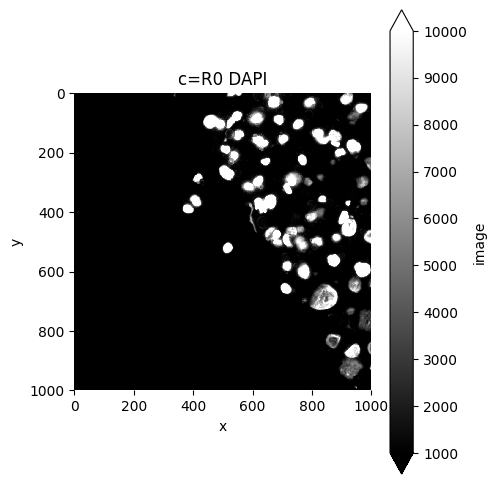

In [148]:
# Plot image from MACSima dataset
hp.pl.plot_shapes(
    sdata_macsima,
    img_layer="HumanLiverH35",
    vmin_img=1000,
    vmax_img=10000,
    channel="R0 DAPI",
    figsize=(5,5,),
    colorbar=True,
    ) # We use the channel argument to specify which channel to plot

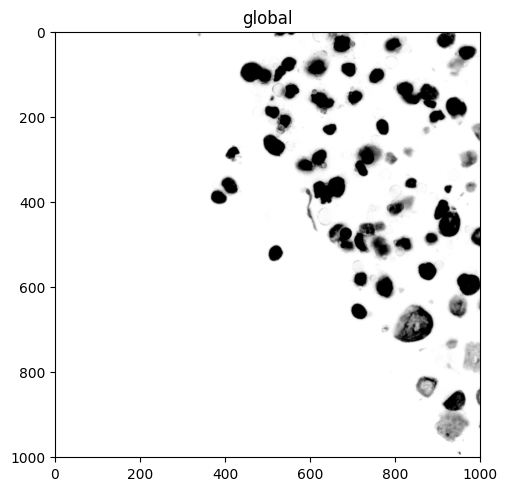

In [140]:
# or using spatialdata-plot
from matplotlib.colors import Normalize

norm = Normalize(vmin=1000, vmax=10000, clip=True)

sdata_macsima.pl.render_images( "HumanLiverH35", channel = "R0 DAPI", norm=norm, cmap="binary", ).pl.show( colorbar=False )

In [ ]:
# Interactive exploration using Napari spatialdata (https://spatialdata.scverse.org/projects/napari/en/latest/index.html)
from napari_spatialdata import Interactive

#Interactive(sdata_macsima)

<b>Excercise</b>:
- Use Napari to interactively explore both the sdata and sdata_macsima SpatialData objects. Try plotting different image layers, multiple channels and changing the contrast and opacity of the images.

## 2.2 Labels

Typically represent a segmentation mask

Labels and images are sometimes referred to as `raster` data.

In [ ]:
# Inspect labels layer
sdata.labels["segmentation_mask"]

In [ ]:
# Compute the numpy array of the labels layer
sdata.labels["segmentation_mask"].data.compute()

In [ ]:
# Inspect data type
sdata.labels["segmentation_mask"].data.compute().dtype # Data type of labels is always int (i.e.: float is not allowed).

In [ ]:
# Plot using spatialdata-plot
sdata.pl.render_images("clahe").pl.render_labels("segmentation_mask", outline_alpha=1.0, fill_alpha=0.8, seg_boundaries=True).pl.show()

In [ ]:
# or a subset
from spatialdata import bounding_box_query

sdata_query=bounding_box_query( sdata, axes = ( "y", "x" ), min_coordinate=[ 1500, 0 ] , max_coordinate=[ 2000,500 ], target_coordinate_system="global" )
sdata_query.pl.render_images("clahe").pl.render_labels("segmentation_mask", outline_alpha=1.0, fill_alpha=0.5, seg_boundaries=True, ).pl.show()

<b>Excercise</b>:

- Calculate the total number of cells (based on the segmentation mask provided).
- Bonus: try not to load the segmentation mask in memory.

<details>
<summary>Click to reveal the solution</summary>

```python
import dask.array as da
len(da.unique(sdata.labels["segmentation_mask"].data).compute())

# Alternatively:
import numpy as np
len(np.unique(sdata.labels["segmentation_mask"].data.compute())) # But this will load the full array into memory

## 2.3 Shapes
Shapes either represent the boundaries of a segmentation mask, or region annotations (e.g. artifacts, tumor regions, ...). 

Shapes are of type GeoDataFrame. They can be manipulated using the [geopandas](https://geopandas.org/en/stable/) library.

In [ ]:
# Inspect shapes layer
sdata.shapes["segmentation_mask_boundaries"]

In [ ]:
# Inspect data type
print(type(sdata.shapes["segmentation_mask_boundaries"])) # Shapes are of type GeoDataFrame and we can use geopandas to manipulate them.

In [ ]:
# Inspect geometry
sdata.shapes["segmentation_mask_boundaries"].geometry.head()

When using `SPArrOW` to generate shapes (via e.g. `hp.im.segment` or `hp.sh.vectorize`), the index of the shapes layer holds the cell id (its name is 'cell_ID') and corresponds to the labels in the corresponding labels layer.

In [ ]:
# Inspect index
sdata.shapes["segmentation_mask_boundaries"].index.name

In [ ]:
# Plot the shapes using SPArrOW
hp.pl.plot_shapes(
    sdata,
    img_layer="clahe",
    shapes_layer="segmentation_mask_boundaries",
    crd=[2000,4000, 2000,4000], # Can be used to crop the image to xmin, xmax, ymin, ymax
    figsize=(5,5,),
)

In [ ]:
# Plot the shapes using spatialdata-plot
sdata_small = sdata.query.bounding_box(
    min_coordinate=[2000, 2000], max_coordinate=[4000, 4000], axes=("x", "y"), target_coordinate_system="global"
) # To crop in spatialdata-plot, we need to do a bounding_box query first

sdata_small.pl.render_images("clahe").pl.render_shapes("segmentation_mask_boundaries", fill_alpha=0.5).pl.show()

## 2.4 Points

Points are DaskDataFrame object (see https://docs.dask.org/en/stable/dataframe.html).

Points represent the spatial location of a feature. In our case this will almost always be a gene.

In [ ]:
# Inspect points layer
sdata.points["transcripts"]

In [ ]:
# Compute points layer as pandas dataframe
sdata.points["transcripts"].compute().head() # This is a pandas.DataFrame 

<b>Excercise</b>:
- Use the points layer `transcripts` to determine how many unique genes were measured.

<details>
<summary>Click to reveal the solution</summary>

```python
sdata.points["transcripts"]["gene"].nunique().compute()

## 2.5 Tables

Tables are [AnnData](https://anndata.readthedocs.io/en/latest/) objects.

In [ ]:
# Inspect tables layer
sdata.tables["table_transcriptomics"]

An `AnnData` object (say `adata`) contains following attributes:

- `adata.X`:  The main data matrix (cells x genes).
- `adata.obs`: Metadata for each cell (e.g., cell type, cluster ID, ...)
- `adata.var`: Metadata for each variable (gene/feature).
- `adata.uns`:  Unstructured information, like color schemes or settings.
- `adata.obsm`: Embeddings or reduced dimensions (e.g., PCA or UMAP coordinates).

### `adata.X`

- This is the core data matrix of the AnnData object, typically an m×n matrix, where m is the number of observations (cells), and n is the number of variables (genes or features).
- Often a sparse or dense NumPy array or SciPy sparse matrix.
- Stores the primary quantitative data for each cell/gene pair, such as raw counts, normalized expression values, or any transformed measurements.

In [ ]:
sdata.tables["table_transcriptomics"].X

In [ ]:
# Get shape of data matrix
sdata.tables["table_transcriptomics"].X.toarray().shape

In [ ]:
# Get matrix as dataframe
sdata.tables["table_transcriptomics"].to_df().head()

### `adata.obs`

- This is a DataFrame-like structure where each row corresponds to an observation in adata.X, typically cells or samples.
- Data type is a `pandas.DataFrame`.
- Stores metadata about each cell, such as cell type labels, sample IDs, batch information, or cluster ID's, cell annotation...

In [ ]:
sdata.tables["table_transcriptomics"].obs.head()

In [ ]:
sdata.tables["table_transcriptomics_clustered"].obs.head()

### `adata.var`

- This is a DataFrame-like structure where each row corresponds to a variable in adata.X, typically representing individual genes or features.
- Data type is a `pandas.DataFrame`.
- Stores metadata about each variable (e.g. gene), such as quality metrics, counts,...

In [ ]:
sdata.tables["table_transcriptomics"].var.head()

In [ ]:
sdata.tables["table_transcriptomics_clustered"].var.head()

### `adata.uns`

- `.uns` (unstructured data) is a dictionary for storing additional, often unstructured, information relevant to the dataset.
- Data type is a dictionary where you can store various data types, such as strings, arrays, or even nested dictionaries.
- Typically used for storing global dataset information, annotations, and visualization settings, like color palettes for clusters or parameter settings for computational methods

In [ ]:
sdata.tables["table_transcriptomics"].uns

### `adata.obsm`

- `.obsm` is a mapping of additional multi-dimensional arrays associated with each observation (cell).
- Data type is a dictionary-like structure where each entry is typically a matrix or array of coordinates.
- Stores embeddings, dimensional reductions, or other coordinate-based data associated with cells

In [ ]:
sdata.tables["table_transcriptomics"].obsm

In [ ]:
sdata.tables["table_transcriptomics"].obsm["spatial"][:5] # Contains centroid coordinates of cells

In [ ]:
sdata.tables["table_transcriptomics_clustered"].obsm

## 3. Region key and Instance key

An AnnData object can be annotated by a spatial element (`labels`, `shapes`, `points`), but AnnData objects generated using `SPArrOW` will be annotated by a `labels` layer.

In [ ]:
from spatialdata.models import TableModel

sdata.tables["table_transcriptomics"].uns[TableModel.ATTRS_KEY]

In [ ]:
from harpy.utils._keys import _INSTANCE_KEY, _REGION_KEY

print('Instance key column: ', _INSTANCE_KEY) # Column in .obs that will be used for cell_ID
print('Region key column: ', _REGION_KEY) # Column in .obs that will be used for linking AnnData object to spatial element (a labels layer, e.g. a segmentation mask).

In [ ]:
# Inspect instance and region keys in obs
sdata.tables["table_transcriptomics_clustered"].obs.head()

In [ ]:
# Segmentation labels correspond to cell_ID values
import dask.array as da
da.unique(sdata.labels["segmentation_mask"].data).compute()[:5] # 0 is not a cell_id, but the value of the background

In [ ]:
# Shapes index correspond to cell_ID values
sdata.shapes['segmentation_mask_boundaries'].index[:5]

In [ ]:
# Plot column of adata.obs using spatialdata-plot (made possible by correct use of instance and region keys)

from matplotlib import pyplot as plt
plt.figure(figsize=(5, 5))
ax = plt.gca()

column = "shapeSize"

sdata.pl.render_images("clahe").pl.render_labels("segmentation_mask", color=column, method="datashader", fill_alpha=1).pl.show(
    coordinate_systems="global", ax=ax, colorbar=False)

In [ ]:
# Plot column of adata.obs using SPArrOW
hp.pl.plot_shapes(
    sdata,
    img_layer="clahe",
    shapes_layer="segmentation_mask_boundaries", # segmentation_mask_boundaries is linked to table layer 'table_transcriptomics_clustered' through cell_ID.
    table_layer="table_transcriptomics_clustered",
    region = "segmentation_mask", # can be set to None in this example, as AnnData is only annotated by one labels layer (single sample).
    column="shapeSize",
    crd=[2000,4000,2000,4000],
    figsize=(5,5,),
    fig_kwargs={ "dpi": 100 },
)

In [ ]:
#Interactive visualization
from napari_spatialdata import Interactive

Interactive(sdata)

## 4. Vectorization and Rasterization

We can go back and forth between labels and shapes using `SPArrOW`. 

Note: `spatialdata` also implements vectorization (`spatialdata.to_polygons`) and rasterization ( `spatialdata.rasterize` ), but these implementations are slower, and require more RAM.

In [ ]:
# Convert labels to shapes layer using sparrow
sdata = hp.sh.vectorize(
    sdata,
    labels_layer="segmentation_mask",
    output_layer="segmentation_mask_boundaries_redo",
    overwrite=True,
)

In [ ]:
# Inspect new shapes layer
sdata.shapes["segmentation_mask_boundaries_redo"]

In [ ]:
# Convert shapes layer to labels layer
sdata = hp.im.rasterize(
    sdata,
    shapes_layer="segmentation_mask_boundaries_redo",
    output_layer="segmentation_mask_redo",
    chunks=5000,
    overwrite=True,
)

<b>Excercise</b>:

- Are the labels layers `segmentation_mask` and `segmentation_mask_redo` equal? Do you expect them to be equal?

<details>
<summary>Click to reveal the solution</summary>

```python
import numpy as np

pixels_not_equal = (~ np.equal(sdata.labels["segmentation_mask_redo"].data.compute(), sdata.labels["segmentation_mask"].data.compute())).sum() 

print(f"After roundtrip vectorization and rasterization, {pixels_not_equal} pixels are not equal.")

print(len(da.unique(sdata.labels["segmentation_mask_redo"].data).compute()))
print(len(da.unique(sdata.labels["segmentation_mask"].data).compute()))

## 5. Coordinate systems

All elements in a `SpatialData` object are assigned to one or more coordinate systems, which allows for storing multiple samples in the same `SpatialData` object.

We refer to [this notebook](https://harpy.readthedocs.io/en/latest/tutorials/advanced/coordinate_systems.html) for more information

In [ ]:
from spatialdata.transformations import get_transformation

get_transformation(sdata.images["clahe"], get_all=True)

In [ ]:
get_transformation(sdata.points["transcripts"], get_all=True)